<a href="https://colab.research.google.com/github/kmouleejunhyuk/bigdata_analysist_practical/blob/main/carprice_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# strategy
# missing & duplicated: 
# poly
# standardscaler
# xgbclassifier
# score: rmse & LOOCV

In [2]:
import pandas as pd
import numpy as np
SEED = 49

In [3]:
raw = pd.read_csv('https://raw.githubusercontent.com/kmouleejunhyuk/bigdata_analysist_practical/main/CarPrice_Assignment.csv')

In [4]:
# from sklearn.model_selection import train_test_split
# train, test = train_test_split(raw, test_size = 0.2)
# train.reset_index(inplace = True)
# test.reset_index(inplace = True)
# train.shape, test.shape

In [5]:
raw.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [6]:
raw.shape

(205, 26)

In [7]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [8]:
raw.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
car_ID,205.0,103.000000,59.322565,1.00,52.00,103.00,154.00,205.00
symboling,205.0,0.834146,1.245307,-2.00,0.00,1.00,2.00,3.00
wheelbase,205.0,98.756585,6.021776,86.60,94.50,97.00,102.40,120.90
carlength,205.0,174.049268,12.337289,141.10,166.30,173.20,183.10,208.10
carwidth,205.0,65.907805,2.145204,60.30,64.10,65.50,66.90,72.30
carheight,205.0,53.724878,2.443522,47.80,52.00,54.10,55.50,59.80
curbweight,205.0,2555.565854,520.680204,1488.00,2145.00,2414.00,2935.00,4066.00
enginesize,205.0,126.907317,41.642693,61.00,97.00,120.00,141.00,326.00
boreratio,205.0,3.329756,0.270844,2.54,3.15,3.31,3.58,3.94
stroke,205.0,3.255415,0.313597,2.07,3.11,3.29,3.41,4.17


In [9]:
##missing & duplicated
raw.isnull().sum()

car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

In [10]:
raw.duplicated().sum()

0

In [13]:
#change unit from inch to cm
raw['carlength'] = raw['carlength'].apply(lambda x: x / 39.37)
raw['carwidth'] = raw['carwidth'].apply(lambda x: x / 39.37)
raw['carheight'] = raw['carheight'].apply(lambda x: x / 39.37)

small_big = []  #1: 중형, 0: 대형
for ind in raw.index:
    if raw.loc[ind, 'carlength'] >= 4.7 or raw.loc[ind, 'carwidth'] >= 1.7 or raw.loc[ind, 'carheight'] >= 2:
        small_big.append(1)
    else:
        small_big.append(0)

raw['small_big'] = small_big
raw

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,small_big
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,4.287529,1.628143,1.239522,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0,0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,4.287529,1.628143,1.239522,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0,0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,4.348489,1.663703,1.330963,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0,0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,4.485649,1.681483,1.379223,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0,0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,4.485649,1.686563,1.379223,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,201,-1,volvo 145e (sw),gas,std,four,sedan,rwd,front,109.1,4.795530,1.750064,1.409703,2952,ohc,four,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0,1
201,202,-1,volvo 144ea,gas,turbo,four,sedan,rwd,front,109.1,4.795530,1.747523,1.409703,3049,ohc,four,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0,1
202,203,-1,volvo 244dl,gas,std,four,sedan,rwd,front,109.1,4.795530,1.750064,1.409703,3012,ohcv,six,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0,1
203,204,-1,volvo 246,diesel,turbo,four,sedan,rwd,front,109.1,4.795530,1.750064,1.409703,3217,ohc,six,145,idi,3.01,3.40,23.0,106,4800,26,27,22470.0,1


In [14]:
#이상치 제거(zscore)
import numpy as np
from scipy import stats
tmp = [x for x in raw.columns if raw[x].dtypes != 'object']
raw = raw[(np.abs(stats.zscore(raw[tmp])) < 3).all(axis=1)]

In [15]:
#범주형 데이터의 종류와 비율 확인
for col in raw.columns:
    if raw[col].dtype == 'object':
        print(col)
        print(raw[col].value_counts(normalize = True), end = '\n\n')

CarName
toyota corolla               0.027624
toyota corona                0.027624
peugeot 504                  0.022099
subaru dl                    0.022099
mitsubishi mirage g4         0.016575
                               ...   
nissan otti                  0.005525
honda civic 1500 gl          0.005525
peugeot 505s turbo diesel    0.005525
bmw x4                       0.005525
mitsubishi montero           0.005525
Name: CarName, Length: 131, dtype: float64

fueltype
gas       0.944751
diesel    0.055249
Name: fueltype, dtype: float64

aspiration
std      0.81768
turbo    0.18232
Name: aspiration, dtype: float64

doornumber
four    0.563536
two     0.436464
Name: doornumber, dtype: float64

carbody
sedan          0.441989
hatchback      0.353591
wagon          0.132597
hardtop        0.038674
convertible    0.033149
Name: carbody, dtype: float64

drivewheel
fwd    0.596685
rwd    0.353591
4wd    0.049724
Name: drivewheel, dtype: float64

enginelocation
front    0.983425
rear    

In [16]:
set([x.split(' ')[0] for x in raw['CarName']])

{'Nissan',
 'alfa-romero',
 'audi',
 'bmw',
 'buick',
 'chevrolet',
 'dodge',
 'honda',
 'isuzu',
 'maxda',
 'mazda',
 'mercury',
 'mitsubishi',
 'nissan',
 'peugeot',
 'plymouth',
 'porcshce',
 'porsche',
 'renault',
 'saab',
 'subaru',
 'toyota',
 'toyouta',
 'volkswagen',
 'volvo',
 'vw'}

In [17]:
#data cleansing
def name_cleansing(input)->list:
    brand_list = []
    for carname in input['CarName']:
        brand = carname.split(sep = ' ')[0].lower()

        if brand in ['vokswagen','volkswagen','vw']:
            brand = 'volkswagen'

        if brand in ['maxda', 'mazda']:
            brand = 'mazda'

        if brand in ['porcshce','porsche']:
            brand = 'porcshce'

        if brand in ['toyota', 'toyouta']:
            brand = 'toyota'

        brand_list.append(brand)

    return brand_list

In [18]:
added_raw = raw.copy()
added_raw['brand'] = name_cleansing(added_raw)
print(added_raw['brand'].value_counts(), end = '\n\n')

toyota         27
nissan         17
mazda          16
mitsubishi     13
honda          12
subaru         12
volvo          10
dodge           9
peugeot         9
volkswagen      8
bmw             7
plymouth        7
audi            7
buick           6
saab            5
porcshce        4
isuzu           4
alfa-romero     3
chevrolet       2
renault         2
mercury         1
Name: brand, dtype: int64



In [19]:
added_raw.drop(['CarName', 'car_ID', 'symboling'], axis = 1, inplace = True)

In [ ]:
#Symboling
#added_raw['symboling'] = added_raw['symboling'].astype('str')

In [20]:
cat_cols= [col for col in added_raw.columns if added_raw[col].dtype=='object']
num_cols= [col for col in added_raw.columns if added_raw[col].dtype!='object']

In [21]:
#labelencoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
added_raw[cat_cols] = added_raw[cat_cols].apply(lambda x: le.fit_transform(x))

In [22]:
dummied_raw = added_raw.copy()

In [23]:
def styler(x, threshold = 0.8):
    if x == 1.0:
        return 'background: white'
    elif x < threshold * -1:
        return 'background: red'
    elif x > threshold:
        return 'background: red'
    else:
        return 'background: green'

In [24]:
dummied_raw.corr().style.applymap(styler)

,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,small_big,brand
fueltype,1.000000,-0.449493,0.164061,-0.136215,-0.301876,0.031394,-0.506763,-0.361107,-0.407558,-0.308481,-0.442889,0.177817,0.208765,-0.293268,0.021335,-0.270438,-0.277310,-0.975351,-0.007651,0.482418,-0.017662,0.070555,-0.305847,-0.358732,0.137591
aspiration,-0.449493,1.000000,0.017216,0.050632,0.101929,-0.061302,0.311625,0.286855,0.373617,0.068630,0.426534,-0.169468,-0.192959,0.233294,0.339169,0.296570,0.246954,0.300975,0.378483,-0.167609,-0.305892,-0.360860,0.279749,0.381680,-0.051890
doornumber,0.164061,0.017216,1.000000,-0.700551,0.099772,0.147515,-0.463082,-0.426742,-0.226684,-0.567491,-0.208859,0.110675,0.149323,-0.046236,0.013998,-0.120605,0.065218,-0.160445,0.096568,0.199479,0.000588,0.023352,-0.063582,-0.206675,-0.140439
carbody,-0.136215,0.050632,-0.700551,1.000000,-0.180734,-0.284335,0.429567,0.348855,0.143884,0.594555,0.124934,-0.061007,-0.078111,-0.096271,-0.081296,0.012585,-0.016233,0.124839,-0.174164,-0.103960,0.048980,0.004748,-0.103819,0.176595,0.093288
drivewheel,-0.301876,0.101929,0.099772,-0.180734,1.000000,0.162060,0.425211,0.454821,0.433668,-0.009315,0.544856,-0.043192,0.272810,0.534856,0.392986,0.462461,0.110415,0.312888,0.490201,-0.095351,-0.416716,-0.410154,0.567099,0.501126,-0.030085
enginelocation,0.031394,-0.061302,0.147515,-0.284335,0.162060,1.000000,-0.209582,-0.050782,-0.050885,-0.109700,0.068538,0.134917,0.220474,0.283847,0.114188,0.202762,-0.167700,-0.001702,0.399387,0.214713,-0.184846,-0.122959,0.423143,-0.075781,0.058726
wheelbase,-0.506763,0.311625,-0.463082,0.429567,0.425211,-0.209582,1.000000,0.852721,0.785857,0.642934,0.738266,-0.203295,-0.202972,0.504212,0.354514,0.478336,0.210597,0.455534,0.295729,-0.366610,-0.397154,-0.482115,0.499827,0.700662,0.038735
carlength,-0.361107,0.286855,-0.426742,0.348855,0.454821,-0.050782,0.852721,1.000000,0.834541,0.535407,0.862416,-0.142487,-0.107104,0.669178,0.540861,0.630147,0.186116,0.304576,0.539213,-0.302475,-0.649054,-0.687753,0.638258,0.729510,0.077200
carwidth,-0.407558,0.373617,-0.226684,0.143884,0.433668,-0.050885,0.785857,0.834541,1.000000,0.330651,0.845461,0.002685,-0.220738,0.697293,0.516550,0.537257,0.252077,0.340720,0.577538,-0.214014,-0.628317,-0.680733,0.711771,0.786113,-0.079350
carheight,-0.308481,0.068630,-0.567491,0.594555,-0.009315,-0.109700,0.642934,0.535407,0.330651,1.000000,0.367013,-0.223805,-0.234830,0.157102,0.010004,0.235046,-0.026810,0.301890,-0.038285,-0.319025,-0.081167,-0.153064,0.175122,0.394842,0.194246


In [25]:
corr_ = dummied_raw.corr()

In [26]:
high_corr = []
for col in corr_.columns:
    for ind in corr_[col].index:
        if corr_.loc[ind, col] >= 0.8 and ind != col:
            if [col, ind] not in high_corr:
                high_corr.append([ind, col])


In [27]:
sorted(high_corr)

[['carlength', 'wheelbase'],
 ['carwidth', 'carlength'],
 ['curbweight', 'carlength'],
 ['curbweight', 'carwidth'],
 ['enginesize', 'curbweight'],
 ['highwaympg', 'citympg'],
 ['horsepower', 'enginesize'],
 ['price', 'curbweight'],
 ['price', 'enginesize']]

In [28]:
#correlation이 높은 컬럼들의 p-value
from scipy.stats import pearsonr

for cols in high_corr:
    print(cols, pearsonr(dummied_raw[cols[0]], dummied_raw[cols[1]]))

['carlength', 'wheelbase'] (0.8527214806983342, 2.294501310175672e-52)
['carwidth', 'carlength'] (0.8345412603946937, 3.2423401734718294e-48)
['curbweight', 'carlength'] (0.8624156908593944, 8.168502074672651e-55)
['curbweight', 'carwidth'] (0.845460539672919, 1.20854635445733e-50)
['enginesize', 'curbweight'] (0.8452733145459197, 1.334984825774834e-50)
['price', 'curbweight'] (0.8023649992864775, 5.584167095212867e-42)
['horsepower', 'enginesize'] (0.8002766032089511, 1.2929512558168918e-41)
['price', 'enginesize'] (0.8304733025766894, 2.3482405514940656e-47)
['highwaympg', 'citympg'] (0.9670118209378402, 3.0067989869394872e-108)


In [29]:
#boreratio와 stroke의 평균이 같은지 검정
from scipy.stats import ttest_ind
print(ttest_ind(dummied_raw['boreratio'], dummied_raw['stroke']))
#이 둘은 평균이 다름

Ttest_indResult(statistic=2.6357173022734917, pvalue=0.008759130978718738)


In [30]:
num_cols.remove('price')

In [31]:
#스케일링
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()

x_train, x_test, y_train, y_test = train_test_split(dummied_raw.loc[:, dummied_raw.columns != 'price'], dummied_raw['price'], test_size = 0.3, random_state = SEED)

col = [s for s in dummied_raw.columns if s != 'price']
x_train, x_test = pd.DataFrame(x_train, columns = col), pd.DataFrame(x_test, columns = col)
x_train[num_cols] = scaler.fit_transform(x_train[num_cols])
x_test[num_cols] = scaler.transform(x_test[num_cols])

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(126, 24) (55, 24) (126,) (55,)


In [ ]:
#pca
# from sklearn.decomposition import PCA
# pca = PCA(n_components=20)
# x_train = pca.fit_transform(x_train)
# x_test = pca.transform(x_test)

# print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
# print(pca.explained_variance_ratio_.sum())

In [ ]:
#polyfit
# from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures(degree = 1)
# x_train = poly.fit_transform(x_train)
# x_test = poly.transform(x_test)

In [32]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

train session val mae: 2026.4409773414525
evalscore: 1763.245170536872


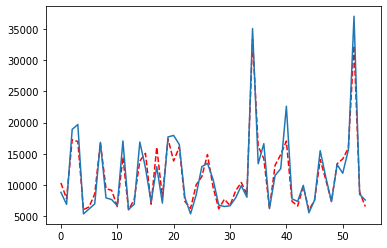

In [37]:
#loocv
from sklearn.feature_selection import RFE
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

#model = XGBRegressor(objective = 'reg:squarederror', random_state = SEED, n_jobs=-1)
model = RandomForestRegressor(random_state = SEED, n_jobs = -1)
rfe_loo = RFE(model, 20)
score_loo = cross_val_score(rfe_loo, x_train, y_train, cv = LeaveOneOut(), scoring = 'neg_mean_squared_error')
rfe_loo.fit(x_train, y_train)

import numpy as np
print(f'train session val mae: {np.sqrt(np.average(score_loo * -1))}')

#evaluating(testdata)
y_hat_loo = rfe_loo.predict(x_test)

from sklearn.metrics import mean_squared_error
print(f'evalscore: {mean_squared_error(y_test.values, y_hat_loo, squared = False)}')

import matplotlib.pyplot as plt
plt.plot(y_hat_loo, '--', c= 'r')
plt.plot(y_test.values)
#그래프 상으로는 적은 데이터 대비 잘 적합하는 것으로 보임

trainsession val rmse: 2856.6849191150877
evalscore: 2060.902356024153


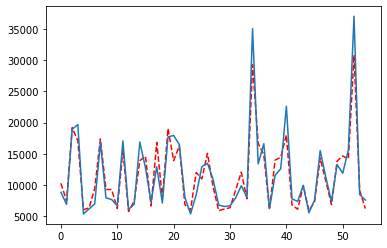

In [38]:
#no cv(holdout, 0.2)
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.feature_selection import RFE

hold_x_train, hold_x_val, hold_y_train, hold_y_val = train_test_split(x_train, y_train, test_size = 0.2)#random_state = SEED)
#model = XGBRegressor(objective = 'reg:squarederror', random_state = SEED, n_jobs=-1)
model = RandomForestRegressor(random_state = SEED, n_jobs = -1)
rfe_hold = RFE(model, 20)
fit = rfe_hold.fit(hold_x_train, hold_y_train)

#validating(hold_x_test)
y_hat_val = rfe_hold.predict(hold_x_val)
print(f'trainsession val rmse: {mean_squared_error(hold_y_val.values, y_hat_val, squared = False)}')

#evaluating(testdata)
y_hat_hold = rfe_hold.predict(x_test)
print(f'evalscore: {mean_squared_error(y_test.values, y_hat_hold, squared = False)}')

import matplotlib.pyplot as plt
plt.plot(y_hat_hold, '--', c= 'r')
plt.plot(y_test.values)
#그래프 상으로는 적은 데이터 대비 잘 적합하는 것으로 보임

In [ ]:
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=49, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)